<a href="https://colab.research.google.com/github/nationalarchives/UKGWA-computational-access/blob/main/Computational_Access_to_UKGWA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is associated with a paper submmitted to Archival Science. The notebook introduces sources of data for computational analysis of the UK Government Web Archive (UKGWA). The purpose of the notebook is not to demonstrate innovative data analysis methods, but rather to illustrate issues and considerations when accessing the collection as data.

The notebooks consists of 3 sections:



1.   Searching for UKGWA within Discovery
2.   Using the CDX API
3.   Using the A-Z Index



## Library imports and behind the scenes setup

Click the run arrow to run several items at once.

In [ ]:
import sys
import os
import shutil
from matplotlib import pyplot
from matplotlib.pyplot import figure
from operator import itemgetter
import datetime
# Function to convert snapshot timestamp to a date
snap_to_date = lambda d : datetime.datetime.strptime(str(d), '%Y%m%d%H%M%S') # %I:%M%p')

In [ ]:
if os.path.isdir('AURA-Article'):
    shutil.rmtree('AURA-Article')
!git clone https://github.com/mark-bell-tna/AURA-Article.git
sys.path.insert(0, 'AURA-Article/Code')
data_folder = "./AURA-Article/Data/"

Cloning into 'AURA-Article'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 106 (delta 43), reused 89 (delta 31), pack-reused 0
Receiving objects: 100% (106/106), 14.94 MiB | 33.54 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
from disco_search import DiscoSearch
from ukgwa_textindex import UKGWATextIndex
from ukgwa_cdx_indexer import TemporalIndexer
from ukgwa_index import UKGWAIndex

## Search for web archive entries in Discovery

Discovery is the online catalogue of The National Archives, UK. For computational access there is an API (Application Programming Interface) which can be explored at this site: https://discovery.nationalarchives.gov.uk/API/sandbox/index

There is no existing indicator in the catalogue for UKGWA sites but all of their descriptions include the words 'web' and 'snapshot(s)'. This is therefore a reliable method of finding UKGWA records, since these would be a rare combination in other contexts.

To simplify the notebook, and because the API has the above sandbox environment for direct experimentation, we have built library code to perform the search. The first code block performs a search and stores the results in a DiscoSearch object called D. DiscoSearch objects are iterable so we can loop over the contents which will return all of the IAIDs of UKGWA records. The code stops after one loop so only shows the first record. The lookup method takes an IAID as an input and returns the data for that record which has been extracted through the API.
To view a record in Discovery itself you can append the IAID to the following URL: https://discovery.nationalarchives.gov.uk/details/r/

<b>Estimated time to run the cell: 30-40 seconds</b>

In [ ]:
D = DiscoSearch()
D.add_entry('web AND snapshots')
for d in D:
    print("IAID:",d,"Data:",D.lookup(d))
    break

IAID: C14142439 Data: ['C14142439', 'Website: Final report, transcripts of hearings, submitted evidence, minutes of meetings, etc. (This snapshot taken on 01/11/2006). [Please Note: These digital records are presented via the UK Government Web Archive ].', '01/01/1998', '01/11/2006', '66/1/C163/0/C16577/0/0/C14142439', '', 'Inquiry into the management of care of children receiving complex heart surgery at the Bristol Royal Infirmary: records: Digital Records formerly in JA 4.', ['C10012 Children', 'C10115 Welfare'], 'JA 11/4']


The get_field method returns the value of a single field from the Data for a given IAID. Run this code block to see the available fields extracted from the API.

In [ ]:
D.fields.keys()

dict_keys(['id', 'description', 'startDate', 'endDate', 'urlParameters', 'adminHistory', 'context', 'taxonomies', 'reference'])

We begin by counting websites by department and printing out the top 10 results. The Department of Health has by far the most sites reflecting the diverse nature of the NHS and its remit around public health messaging.

In [ ]:
departments = {}
for idx in D:
    dep = D.get_field(idx, "reference").split(" ")[0]
    if dep in departments:
        departments[dep] += 1
    else:
        departments[dep] = 1

top_deps = sorted([[k,v] for k,v in departments.items()], key=itemgetter(1), reverse=True))
for d in top_deps[0:10]:
    print(d[0], "Sites:", d[1])

This code block extracts the startDate field, extracts the year (last 4 characters) and produces a summary counting records per year. Blank years and those earlier than 1996 (year the UKGWA started) are filtered out (very few are removed by this step but the chart is cleaner). The results are then visualised in a bar chart.

<BarContainer object of 24 artists>

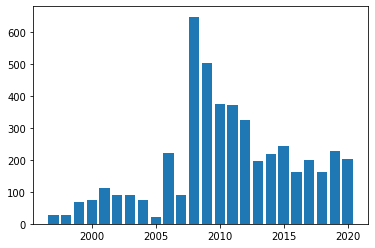

In [ ]:
years = {}
for idx in D:
    yr = D.get_field(idx, "startDate")[-4:]
    if yr.isnumeric():
        yr = int(yr)
    else:
        continue
    if yr >= 1996:
        if yr in years:
            years[yr] += 1
        else:
            years[yr] = 1

years, counts = zip(*sorted([[y,c] for y,c in years.items()], key=itemgetter(0), reverse=False))

pyplot.bar(years,counts)

Catalogue records are usually assigned one or more taxonomy categories. Here we summarise the records by category and print out the top 10 (set value of N to print more) most common categories.



In [ ]:
N = 10  # Change this value to see more (or fewer) rows

taxonomies = {}
for idx in D:
    tax = D.get_field(idx, "taxonomies")
    for t in tax:
        if t in taxonomies:
            taxonomies[t] += 1
        else:
            taxonomies[t] = 1

sorted_taxonomies = sorted([(k,v) for k,v in taxonomies.items()], key=itemgetter(1), reverse=True)
for i in range(N):
    print(sorted_taxonomies[i])

('C10136 Official publications', 3843)
('C10070 National Health Service', 172)
('C10036 Farming', 86)
('C10108 Trade and commerce', 75)
('C10039 Food and drink', 74)
('C10052 Labour', 58)
('C10105 Sports', 56)
('C10077 Pay and pensions', 52)
('C10096 Research', 45)
('C10043 Government finances', 45)


Create a searchable index of the text from record descriptions. There is no data cleaning step involved here so punctuation is not removed. However, stop words are removed - the list of included stop words is in the code and can be changed by adding words in quotes, with a comma between words.

<b> Estimated run time: 30 seconds </b>

In [ ]:
T_Desc = UKGWATextIndex(stop_words = ["", "and", "of", "the", "in", "a", "by", "which", "their","as","an",
                                 "for","to","if","be","this","on","are","at","were","it","is","that",
                                 "from","been","has","have","or","there","was","they","with","these"])

for idx in D:
    desc = D.get_field(idx, "description")
    T_Desc.add_entry(idx, desc.split(" "))

Get the most common N phrases from the text index. Again change the value of N to see more rows.
The code prints out a phrase alongside a count of occurrences of that phrase in the descriptions.
We see that the descriptions are generally formulaic, boilerplate, text explaining the archival process behind creating snapshots of web sites.

In [ ]:
N = 5  # Change this value to see more top phrases

P = T_Desc.get_phrases(min_count = 20, min_length = 2)  # Phrases occurring at least 20 times with at least 2 words in them
P.sort(key=itemgetter(1), reverse=True)
for p in P[:N]:
    print(" ".join(p[0]), p[1])

series contains dated gathered versions (or 'snapshots') 2830
website. [please note: records may accessed via uk government web archive ]. 2673
website. [please note: records may accessed via uk government web archive using links listed below (for general explanation parallel links, please see arrangement field)]: 488
series contains links gathered versions (or 'snapshots') 435
website. [please note: records may accessed via uk government web archive]. 306


Repeat the indexing steps but this time using the the Administrative History of the records if they have one.

<b>Estimated time to run: 35s</b>

In [ ]:
T_Admin = UKGWATextIndex(stop_words = ["", "and", "of", "the", "in", "a", "by", "which", "their","as","an",
                                 "for","to","if","be","this","on","are","at","were","it","is","that",
                                 "from","been","has","have","or","there","was","they","with","these"])

for idx in D:
    admin = D.get_field(idx, "adminHistory")
    T_Admin.add_entry(idx, admin.split(" "))

Print out the top N phrases. This time the phrases are more informative but the coverage is a lot less.

In [ ]:
N = 20  # Change this value to see more phrases.

P = T_Admin.get_phrases(min_count = 15, min_length = 2)  # Phrases occurring at least 15 times with at least 2 words in them
P.sort(key=itemgetter(1), reverse=True)
for p in P[:N]:
    print(" ".join(p[0]), p[1])

set up 96
1 april 77
secretary state 62
uk government 62
executive agency 35
regional development 34
department education 34
east midlands 31
development agency 31
public sector 31
local government 30
england wales. 30
department health 30
east england 29
advisory non-departmental public body 28
higher education 28
funded department 28
northern ireland 27
advisory committee 27
legal services 26


## Using the CDX API - temporal analysis of the web archive

CDX is a data format output by the Heritrix web crawler that captures high level information about an archived web resource, such as: snapshot date, mime type, status code (e.g. 200, 404), checksum.

We can use it to view the snapshot history of a site, and will use the Environment Agency home page as an example.
The TemporalIndexer object contains library code to query the CDX API for a site, store the results, but also calculate minimum and maximum dates.

In [ ]:
T = TemporalIndexer()
website = 'www.environment-agency.gov.uk'
T.add_entry(website)
[(T.field_list[i], v) for i,v in enumerate(T.lookup(website))]

[('MIN', 19961104034437),
 ('MAX', 20210330043843),
 ('COUNT', 840),
 ('CDX', <ukgwa_cdx_reader.CDXReader at 0x7f77ce0ce490>)]

We can plot the history of a website and changes over time using the CDX data. The checksum from CDX is used to derive a CHANGED indicator to show whether a page has been updated in any way since the previous snapshot.

In the graph output, the upper (black) points represent unchanged snapshots, and the lower (pink) points represent those which have changed. We see the density of points increasing between 2008 and 2014 indicating increased archiving activity. This results in more duplicate pages but also suggests a greater percentage of updates are being captured. Contrast with 2004-2008 where we can not be sure all changes are represented in the archive. After 2014 all of the dots are black. Analysis of status code for these snapshots shows that the page was redirected in 2014 and the redirect message itself remains consistent throughout.

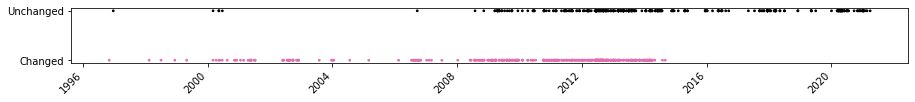

In [ ]:
cdx_data = T.get_field(website, 'CDX')
date_list = [snap_to_date(x) for x in cdx_data]
changes = [cdx_data.get_field(c, 'CHANGED') for c in cdx_data]
colour_list = ['#e56db1' if c else '#000000' for c in changes]
xs = date_list
ys = [-1 if c else 1 for c in changes]
figure(figsize=(15, 1))
pyplot.scatter(xs, ys, s=3, c = colour_list)
pyplot.xticks(rotation=45, ha='right')
pyplot.yticks([-1,1], ['Changed','Unchanged'])
pyplot.show()

That was for a single page. What happens if we wish to analyse more pages? We can use the code from earlier to loop through a list of urls and read their snapshot details from the CDX data. However, that could be seen as computationally wasteful if every user of the notebook requests details of the same pages.
Once a row of CDX data is created, it does not change. So we have created an extract of the data which can be loaded into our TemporalIndexer. This does not mean the file will always be up to date, but it provides a baseline set of data which could be appended to via the API which will require less processing time than a full refresh.
This data is based on a list of all of the home pages found in the A-Z index of the UKGWA. The A-Z data will be looked at in the next section of this notebook.

In [ ]:
T.load_from_gzip(data_folder + "ukgwa_cdx_data.psv.gz")

Having loaded the CDX data we can now recreate the barchart created from the catalogue but this time using data generated by the archiving process.
We can see by comparing the two charts that there are a few differences, particularly in the pre-2005 section. This is understandable for a few reasons. The Discovery catalogue is updated manually rather than through an automated feed, so we can not expect it to be completely up to date - there are many competing priorities in cataloguing. Secondly, the start date in the catalogue may reflect the date of documents related to the web archive but not the web archive itself.
This kind of data driven analysis does highlight the discrepancies between the two sources though, and should trigger further investigation to understand whether the differences are in interpretation, or due to data quality.

<BarContainer object of 26 artists>

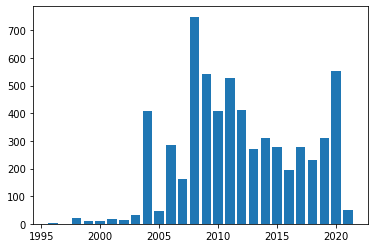

In [ ]:
cdx_years = {}
for idx in T:
    yr = str(T.get_field(idx, "MIN"))[:4]
    if yr.isnumeric():
        yr = int(yr)
    else:
        continue
    if yr >= 1996:
        if yr in cdx_years:
            cdx_years[yr] += 1
        else:
            cdx_years[yr] = 1

years, counts = zip(*sorted([[y,c] for y,c in cdx_years.items()], key=itemgetter(0), reverse=False))

pyplot.bar(years,counts)

## UKGWA's A to Z index

The A-Z index lists every website which has been archived by UKGWA. It is held in an HTML page and so the text and urls need to be scraped from that page and transformed into data.

This library code does just that. The UKGWAIndex object is a container for the data, and the indexfromweb method reads the data from the A-Z web page.

In [ ]:
W = UKGWAIndex()
W.indexfromweb()
W.lookup('UKGWA.1')

['UKGWA.1',
 'A sample campaign – Just another GOV.UK campaigns site',
 '*',
 'https://sample.campaign.gov.uk/',
 'N']

The fields list shows there are 5 fields in the data. The REF is autogenerated and is meaningless outside the context of this notebook (e.g. UKGWA.1). The TEXT field is a description of the website, and URL is self-explantory. The CAT field shows what kind of web resource the URL points to. For web pages this value will be set to '*', but you will also find values such as 'twitter' and 'youtube'. The notebook will focus on the '*' URLs since the social media ones are not meant for computational access. The 'CATREF' field requires supplementary data but provides a link between UKGWA and Discovery.

In [ ]:
W.field_list

['REF', 'TEXT', 'CAT', 'URL', 'CATREF']

The next two items of code will look familiar, they index the description text to find common phrases in the descriptions.

<b>Estimate run time: 10 seconds</b>

In [ ]:
T_ukgwa = UKGWATextIndex(stop_words = ["", "and", "of", "the", "in", "a", "by", "which", "their","as","an",
                                 "for","to","if","be","this","on","are","at","were","it","is","that",
                                 "from","been","has","have","or","there","was","they","with","these"])
for w in W:
    if W.get_field(w, 'CAT') == '*':
        T_ukgwa.add_entry(w, W.get_field(w, "TEXT").split(" "))

The descriptions are often in two parts with a '-' separating them, with each part having a different meaning. Which is why '- gov.uk blog' comes out as a top hit. A better way to index this text is by breaking descriptions into two using that '-' as a delimiter. But this simple approach does enough to highlight the types of material in the web archive. NHS is obviously a very large department but has considerably more sites than other departments, perhaps highlighting the diversity of its remit. A number of sites are marked as being related to 'covid-19', a piece of information that was visible in Discovery. 

In [ ]:
 N = 10  # Return top 15 results (by count)

P = T_ukgwa.get_phrases(min_count = 5, min_length = 2)  # Phrases occurring at least 20 times with at least 2 words in them
P.sort(key=itemgetter(1), reverse=True)
for p in P[:N]:
    print(" ".join(p[0]), p[1])

– gov.uk blog 138
national health service (nhs) – 117
gov.uk – 90
national health service (nhs) 85
national institute health research (nihr) – 60
advisory committee 59
– covid-19 41
hm revenue & customs (hmrc) – 36
directgov – 35
department environment, food rural affairs (defra) – 34


There is no direct link between UKGWA and the Discovery API. The catalogue entries in Discovery do contain the URL but this is not surfaced through the API. We are therefore providing a data file to create this connection. The data file is not automatically updated and is unlikely to be frequently maintained, however, so more recent additions to the archive will not be reflected.

The file is held in the Github repository and can be loaded through a library function. We now see that the fifth field in the data has been populated with a catalogue entry. This is the case for most but not all of the entries in the A-Z index.

In [ ]:
W.discoveryfromfile(data_folder + 'ukgwa_catrefs.txt')
W.lookup('UKGWA.1')

['UKGWA.1',
 'A sample campaign – Just another GOV.UK campaigns site',
 '*',
 'https://sample.campaign.gov.uk/',
 'GUK 207']

In [ ]:
c = 0
for idx in D:
    admin = D.get_field(idx, "adminHistory")
    if len(admin.split(" ")) > 50:
        print(idx, admin)
        c += 1
        if c == 5:
            break

C13497801 The Joint Health Claims Initiative (JHCI) was launched in December 2000 as the UK body, made up of representatives of the food industry, consumer interest groups and enforcement authorities, which aimed to provide voluntary advice on the truthfulness of health claims for foods. It closed in March 2007. (Please Note: these snapshots were retrospectively taken in 2013 of this website which dates from 2007).
C17986 Investors in People UK was formed in 1993 to provide business leadership and development for the investors in people standard, and to lead and undertake national promotion of the standard. The snapshots in this series begin in the period before June 2007 when it was the responsibility of the Department for Education and Skills, before becoming a non-departmental public body which receives funding from the Department for Business, Innovation and Skills (BIS).
C11689435 The GovernorLine web site was established in May 2002 and offers free, confidential advice, informati